In [1]:
# built-in python modules
import os
import inspect

# scientific python add-ons
import numpy as np
import pandas as pd

# plotting stuff
# first line makes the plots appear in the notebook
%matplotlib inline 
import matplotlib.pyplot as plt
# seaborn makes your plots look better
try:
    import seaborn as sns
    sns.set(rc={"figure.figsize": (12, 6)})
except ImportError:
    print('We suggest you install seaborn using conda or pip and rerun this cell')

# finally, we import the pvlib library
import pvlib

In [3]:
# absolute path to a data file
datapath = os.path.join("/Users/Vlasis/Desktop", 'Eindhoven_HTC-hour.csv')

# read tmy data with year values coerced to a single year
tmy_data, meta = pvlib.tmy.readtmy3(datapath, coerce_year=2015)
tmy_data.index.name = 'Time'

# TMY data seems to be given as hourly data with time stamp at the end
# shift the index 30 Minutes back for calculation of sun positions
tmy_data = tmy_data.shift(freq='-30Min')

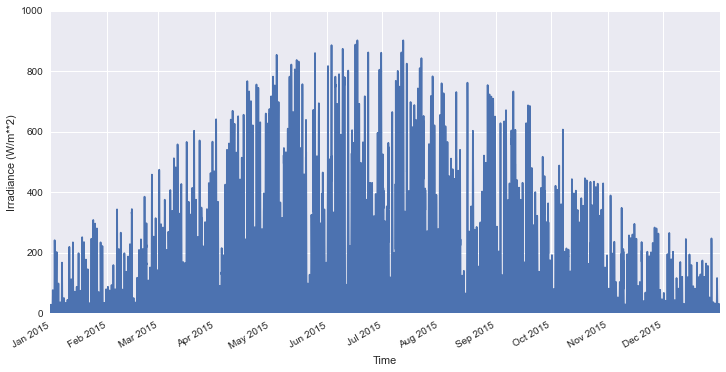

In [4]:
tmy_data.GHI.plot()
plt.ylabel('Irradiance (W/m**2)')

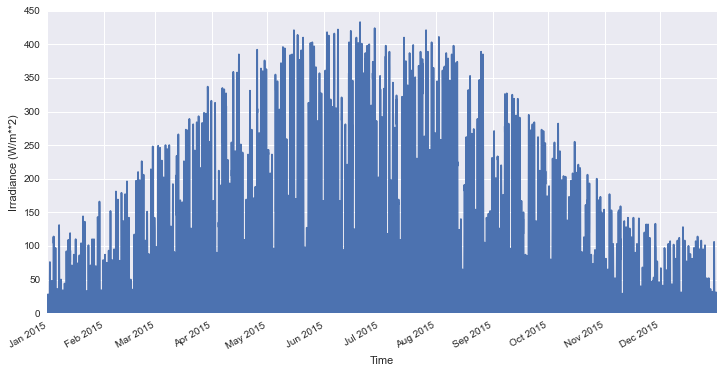

In [5]:
tmy_data.DHI.plot()
plt.ylabel('Irradiance (W/m**2)')

In [9]:
surface_tilt = 30
surface_azimuth =-15 # pvlib uses 0=North, 90=East, 180=South, 270=West convention
albedo = 0.2

# create pvlib Location object based on meta data
sand_point = pvlib.location.Location(meta['latitude'], meta['longitude'], tz="Europe/Amsterdam", 
                                     altitude=meta['altitude'], name=meta['Name'].replace('"',''))
print(sand_point)

Eindhoven HTC: latitude=51.41, longitude=5.455, tz=Europe/Amsterdam, altitude=30.0


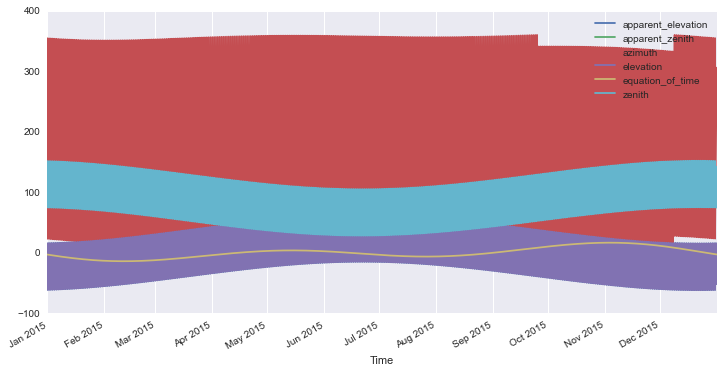

In [10]:
solpos = pvlib.solarposition.get_solarposition(tmy_data.index, sand_point)

solpos.plot()

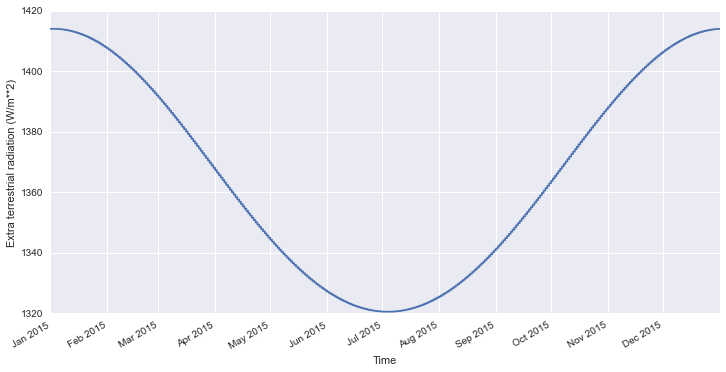

In [11]:
# the extraradiation function returns a simple numpy array
# instead of a nice pandas series. We will change this
# in a future version
dni_extra = pvlib.irradiance.extraradiation(tmy_data.index)
dni_extra = pd.Series(dni_extra, index=tmy_data.index)

dni_extra.plot()
plt.ylabel('Extra terrestrial radiation (W/m**2)')

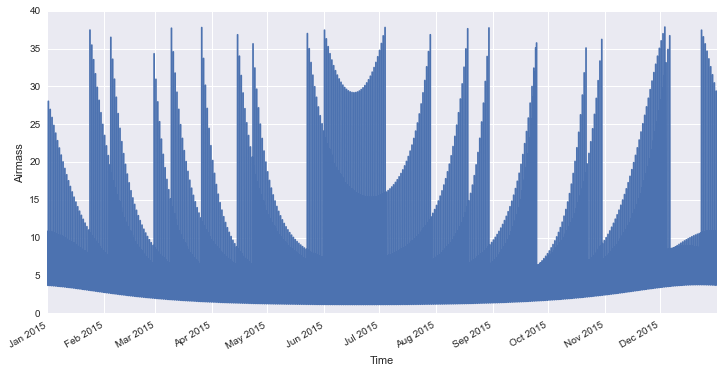

In [12]:
airmass = pvlib.atmosphere.relativeairmass(solpos['apparent_zenith'])

airmass.plot()
plt.ylabel('Airmass')

In [13]:
diffuse_irrad = pd.DataFrame(index=tmy_data.index)

models = ['Perez', 'Hay-Davies', 'Isotropic', 'King', 'Klucher', 'Reindl']

In [14]:
'''PEREZ'''

diffuse_irrad['Perez'] = pvlib.irradiance.perez(surface_tilt,
                               surface_azimuth,
                               dhi=tmy_data.DHI,
                               dni=tmy_data.DNI,
                               dni_extra=dni_extra,
                               solar_zenith=solpos.apparent_zenith,
                               solar_azimuth=solpos.azimuth,
                               airmass=airmass)

'''HayDavies '''
diffuse_irrad['Hay-Davies'] = pvlib.irradiance.haydavies(surface_tilt,
                               surface_azimuth,
                               dhi=tmy_data.DHI,
                               dni=tmy_data.DNI,
                               dni_extra=dni_extra,
                               solar_zenith=solpos.apparent_zenith,
                               solar_azimuth=solpos.azimuth)
'''Isotropic'''

diffuse_irrad['Isotropic'] = pvlib.irradiance.isotropic(surface_tilt,
                               dhi=tmy_data.DHI)

'''Klucher Model'''
diffuse_irrad['Klucher'] = pvlib.irradiance.klucher(surface_tilt, surface_azimuth,
                                                    dhi=tmy_data.DHI,
                                                    ghi=tmy_data.GHI,
                                                    solar_zenith=solpos.apparent_zenith,
                                                    solar_azimuth=solpos.azimuth)

'''Reindl'''
diffuse_irrad['Reindl'] = pvlib.irradiance.reindl(surface_tilt,
                               surface_azimuth,
                               dhi=tmy_data.DHI,
                               dni=tmy_data.DNI,
                               ghi=tmy_data.GHI,
                               dni_extra=dni_extra,
                               solar_zenith=solpos.apparent_zenith,
                               solar_azimuth=solpos.azimuth)



In [15]:
'''Calculate yearly, monthly, daily sums'''
yearly = diffuse_irrad.resample('A', how='sum').dropna().squeeze() / 1000.0  # kWh
monthly = diffuse_irrad.resample('M', how='sum', kind='period') / 1000.0
daily = diffuse_irrad.resample('D', how='sum') / 1000.0

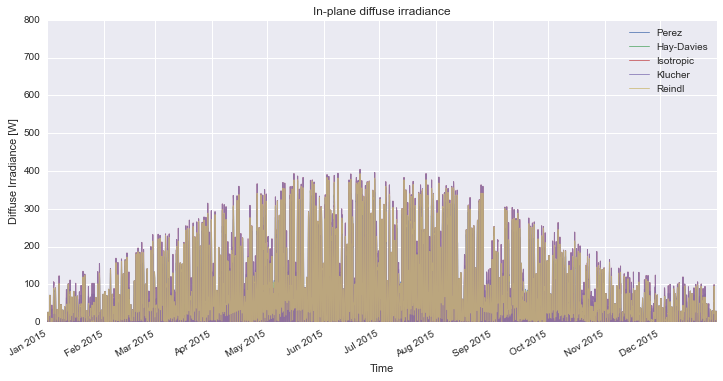

In [25]:
'''PLOTING RESULTS'''
ax = diffuse_irrad.plot(title='In-plane diffuse irradiance', alpha=.75, lw=1)
ax.set_ylim(0, 800)
ylabel = ax.set_ylabel('Diffuse Irradiance [W]')
plt.legend()
plt.savefig("/Users/Vlasis/Desktop/figure.png")  


In [18]:
diffuse_irrad.describe()

,Perez,Hay-Davies,Isotropic,Klucher,Reindl
count,4464.000000,8760.000000,8760.000000,8760.000000,4575.000000
mean,109.354903,56.357391,61.072178,61.072178,108.569127
std,86.623323,87.191994,92.085077,92.085077,95.467882
min,0.933013,0.000000,0.000000,0.000000,0.000000
25%,41.052559,0.000000,0.000000,0.000000,32.466939
50%,85.340474,0.933013,1.866025,1.866025,79.306080
75%,163.231320,83.971143,92.368257,92.368257,166.244614
max,357.950649,389.640222,403.994500,403.994500,392.638152


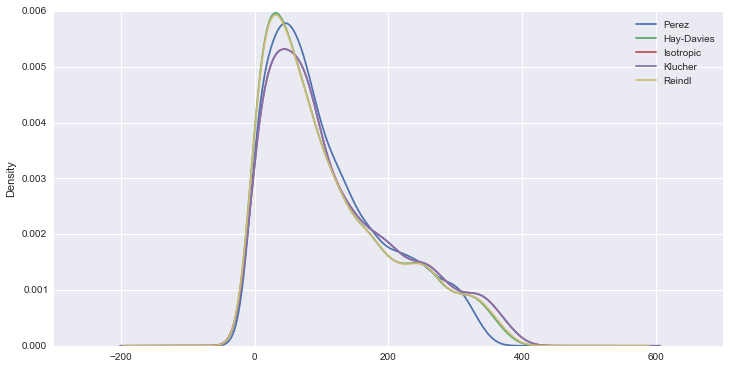

In [19]:
diffuse_irrad.dropna().plot(kind='density')

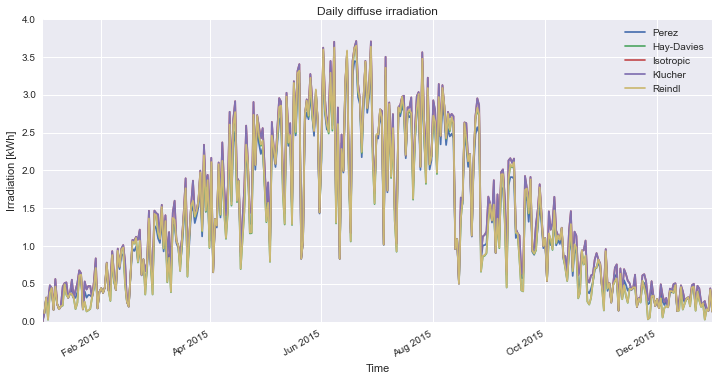

In [20]:
'''DAILY'''

ax_daily = daily.tz_convert('UTC').plot(title='Daily diffuse irradiation')
ylabel = ax_daily.set_ylabel('Irradiation [kWh]')

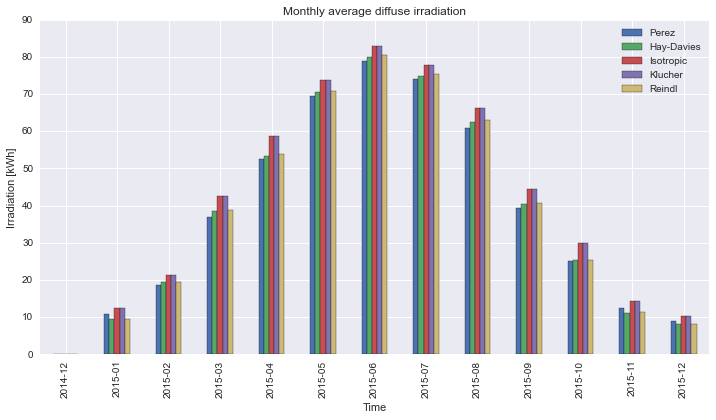

In [21]:
'''MONTHLY'''
ax_monthly = monthly.plot(title='Monthly average diffuse irradiation', kind='bar')
ylabel = ax_monthly.set_ylabel('Irradiation [kWh]')

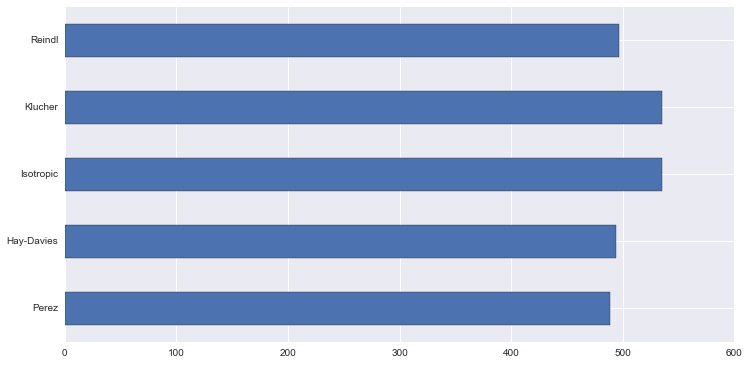

In [22]:
'''YEARLY'''
yearly.plot(kind='barh')

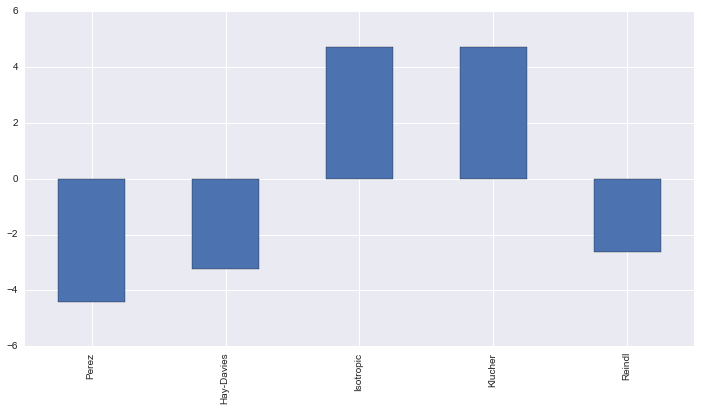

In [23]:
'''YEARLY'''
mean_yearly = yearly.mean()
yearly_mean_deviation = (yearly - mean_yearly) / yearly * 100.0
yearly_mean_deviation.plot(kind='bar')